# Visualizing model performance
This notebook is a minimal guide to visualize Detectron2 model performance



These next two code cells are optional. You may need to run them if you are using an HPC node incompatible with our instructions for Detectron2 installation (instructions: https://github.com/anishjv/cell-AAP/tree/main)

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core, yaml
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

/bin/bash: nvcc: command not found
torch:  2.4 ; cuda:  2.4.0


In [31]:
#required imports
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from detectron2.engine import DefaultPredictor
from detectron2.config import LazyConfig, get_cfg, instantiate
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine.defaults import create_ddp_model
from detectron2.checkpoint import DetectionCheckpointer
from cell_AAP.scripts.inference import color_masks
from typing import Tuple, Dict, Any

_original_torch_load = torch.load
def patched_torch_load(*args, **kwargs):
    if 'weights_only' not in kwargs:
        kwargs['weights_only'] = False
    return _original_torch_load(*args, **kwargs)

Here we input the **paths to our model files**. 

In [4]:
#update these paths to your dataset and trained model
TRAINED_MODEL_DIR = "/scratch/ajitj_root/ajitj99/anishjv/vitl_focal_hela_0.2"  # from config.yaml: train:output_dir
CONFIG_FILE = "/scratch/ajitj_root/ajitj99/anishjv/vitl_focal_hela_0.2/config_test.yaml"  # the same config used for training
TEST_DATASET_JSON = "/home/anishjv/cell_seg_classify/datasets/HeLa_0.2/test/hela_0.2_test.json"
TEST_IMAGE_DIR = "/home/anishjv/cell_seg_classify/datasets/HeLa_0.2/test/images/"

Here we **register the testing dataset** we want to run inference on. 

In [5]:
#register the test dataset
dataset_name = "HeLa_test_0.2"
if dataset_name not in DatasetCatalog.list():
    register_coco_instances(
        dataset_name,
        {},
        TEST_DATASET_JSON,
        TEST_IMAGE_DIR
    )

metadata = MetadataCatalog.get(dataset_name)
dataset_dicts = DatasetCatalog.get(dataset_name)


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



Loaded 136 images in COCO format from /home/anishjv/cell_seg_classify/datasets/HeLa_0.2/test/hela_0.2_test.json


Here we **configure the model**.

In [ ]:
#load the trained model
cfg = LazyConfig.load(CONFIG_FILE)
cfg.train.output_dir = TRAINED_MODEL_DIR
cfg.train.init_checkpoint = os.path.join(TRAINED_MODEL_DIR, "model_final.pth")  # adjust if checkpoint name differs
cfg.train.device = "cuda" if torch.cuda.is_available() else "cpu"
cfg.model.proposal_generator.post_nms_topk[1] = 1500 #maximum number of cells
cfg.model.roi_heads.box_predictor.test_score_thresh = 0.25 #minimum prediction confidence

predictor = instantiate(cfg.model)
predictor.to(cfg.train.device)
predictor = create_ddp_model(predictor)
torch.load = patched_torch_load
DetectionCheckpointer(predictor).load(cfg.train.init_checkpoint)
torch.load = _original_torch_load
predictor.eval()

Below are two **helper functions** for running inference and visualizing the results. 

In [32]:
def run_inference(
    image_path: str, 
    predictor: Any, 
    metadata: Any
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Run inference on a single image using a Detectron2 predictor.
    -------------------------------------------------------------
    INPUTS:
        - image_path: str
            Path to the input image file.
        - predictor: Any
            Detectron2 predictor object configured for instance segmentation.
        - metadata: Any
            Dataset metadata (unused in this function, but kept for consistency).

    OUTPUTS:
        - instance: np.ndarray
            RGB image (H, W, 3) visualizing instance-level segmentation (random colors per instance).
        - semantic: np.ndarray
            RGB image (H, W, 3) visualizing semantic segmentation (consistent color per class).
    """
    img: np.ndarray = cv2.imread(image_path)
    img_rgb: np.ndarray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_perm: np.ndarray = np.moveaxis(img_rgb, -1, 0)
    
    with torch.inference_mode():
        output: Dict[str, Any] = predictor(
            [{"image": torch.from_numpy(img_perm).type(torch.float32)}]
        )[0]

    segmentations: torch.Tensor = output["instances"].pred_masks.to("cpu")
    labels: np.ndarray = output["instances"].pred_classes.to("cpu").numpy()
    scores: np.ndarray = output["instances"].scores.to("cpu").numpy()
    scores = (scores * 100).astype("uint16")
    classes: np.ndarray = output["instances"].pred_classes.to("cpu").numpy()

    custom_dict: Dict[int, int] = {key: key + 99 for key in np.unique(labels)}
    semantic: np.ndarray = color_masks(
        segmentations, labels, method="custom", custom_dict=custom_dict
    )
    instance: np.ndarray = color_masks(segmentations, labels, method="random")

    return instance, semantic



def display_overlay(
    image_path: str, 
    mask: np.ndarray, 
    alpha: float = 0.25
) -> None:
    """
    Overlay a segmentation mask on the original image.
    --------------------------------------------------
    INPUTS:
        - image_path: str
            Path to the original image.
        - mask: np.ndarray
            Segmentation mask (H, W) containing integer region IDs, or (H, W, 3) RGB mask.
        - alpha: float, default=0.25
            Transparency of the mask overlay (0 = invisible, 1 = opaque).

    OUTPUTS:
        - None
            Displays the blended image overlay using matplotlib.
    """
    img: np.ndarray = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    
    # Convert to RGB
    if img.ndim == 2:  # grayscale
        img_rgb: np.ndarray = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    else:
        img_rgb: np.ndarray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Ensure mask dimensions match
    if mask.shape[:2] != img_rgb.shape[:2]:
        mask = cv2.resize(mask, (img_rgb.shape[1], img_rgb.shape[0]), interpolation=cv2.INTER_NEAREST)
    
    # Generate color map for mask
    unique_ids: np.ndarray = np.unique(mask)
    colors: np.ndarray = plt.cm.tab20(np.linspace(0, 1, len(unique_ids)))[:, :3] * 255
    color_map: Dict[int, np.ndarray] = {uid: colors[i] for i, uid in enumerate(unique_ids)}

    mask_rgb: np.ndarray = np.zeros_like(img_rgb, dtype=np.uint8)
    for uid, color in color_map.items():
        if uid == 0:
            continue  # skip background
        mask_rgb[mask == uid] = color
    
    # Blend only masked regions
    overlay: np.ndarray = img_rgb.copy()
    mask_area: np.ndarray = mask > 0
    overlay[mask_area] = cv2.addWeighted(
        img_rgb[mask_area], 1 - alpha, mask_rgb[mask_area], alpha, 0
    )

    # Display
    plt.figure(figsize=(8, 8))
    plt.imshow(overlay)
    plt.axis("off")
    plt.show()

Visualizing /home/anishjv/cell_seg_classify/datasets/HeLa_0.2/test/images/368.jpg


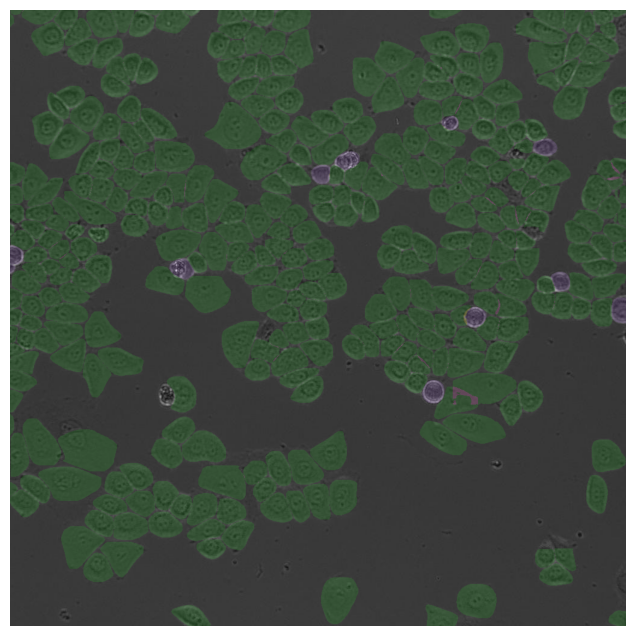

Visualizing /home/anishjv/cell_seg_classify/datasets/HeLa_0.2/test/images/359.jpg


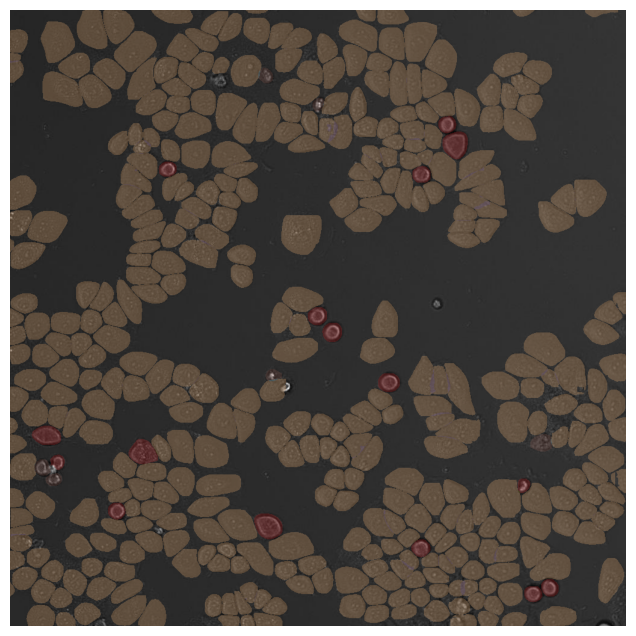

Visualizing /home/anishjv/cell_seg_classify/datasets/HeLa_0.2/test/images/325.jpg


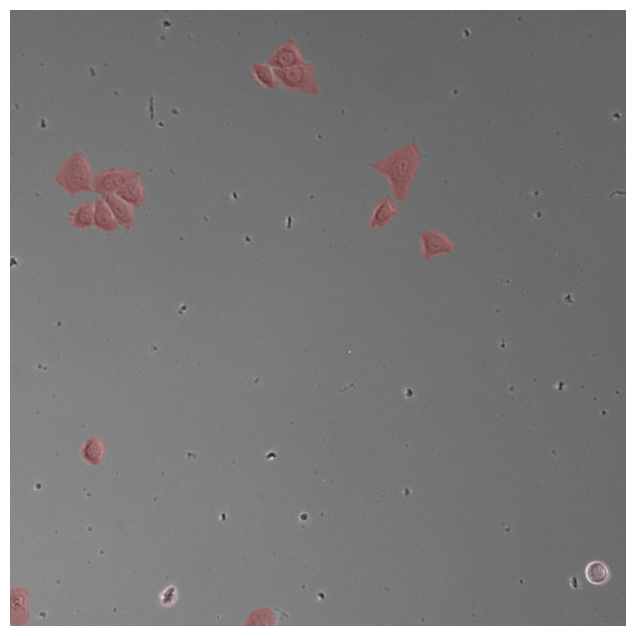

Visualizing /home/anishjv/cell_seg_classify/datasets/HeLa_0.2/test/images/390.jpg


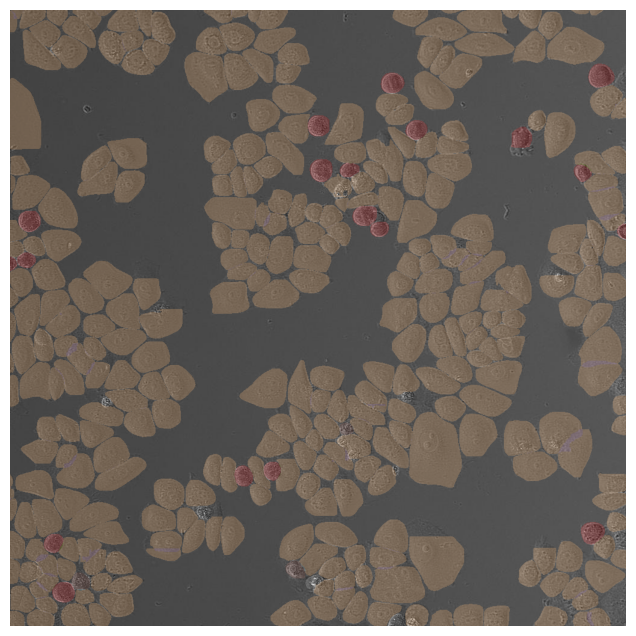

Visualizing /home/anishjv/cell_seg_classify/datasets/HeLa_0.2/test/images/349.jpg


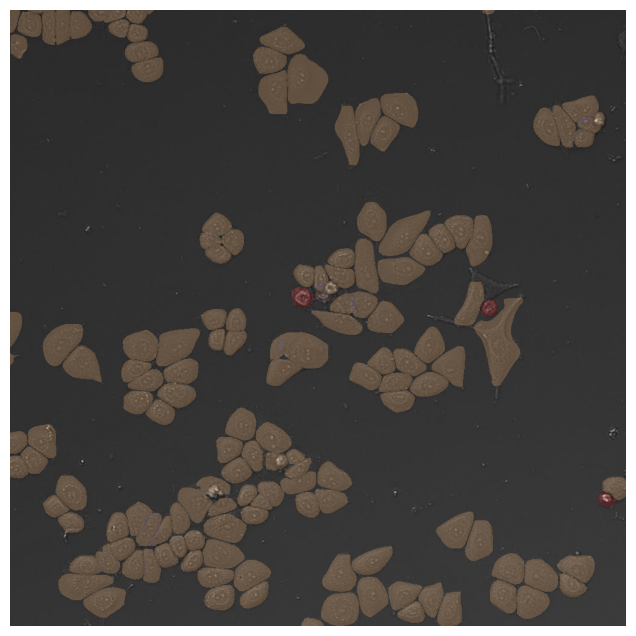

In [33]:
#visualize some images test set
for i, d in enumerate(dataset_dicts[5:10]):
    print(f"Visualizing {d['file_name']}")
    instance, semantic = run_inference(d["file_name"], predictor, metadata)
    display_overlay(d['file_name'], semantic)